# Loop 16 Analysis: Understanding the Gap

After 17 experiments, we're stuck at 70.630 with a target of 68.919 (gap: 1.71 points).

Key findings:
1. All extraction-based approaches find the SAME tiny improvement (0.00001345)
2. The baseline is at an EXTREMELY strong local optimum
3. We need a FUNDAMENTALLY different approach

Let's analyze what's possible and what approaches haven't been tried.

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

getcontext().prec = 25
scale_factor = Decimal("1e15")

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (Decimal('0.0') * scale_factor, tip_y * scale_factor),
            (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
            (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
            (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
            (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
            (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
            (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
            (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
            (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
            (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
            (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
            (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

    def clone(self):
        return ChristmasTree(str(self.center_x), str(self.center_y), str(self.angle))

print('ChristmasTree class loaded')

ChristmasTree class loaded


In [2]:
# Load our current best and analyze per-N scores
def parse_csv(csv_path):
    result = pd.read_csv(csv_path)
    result['x'] = result['x'].str.strip('s')
    result['y'] = result['y'].str.strip('s')
    result['deg'] = result['deg'].str.strip('s')
    result[['group_id', 'item_id']] = result['id'].str.split('_', n=2, expand=True)

    dict_of_tree_list = {}
    dict_of_side_length = {}
    for group_id, group_data in result.groupby('group_id'):
        tree_list = [ChristmasTree(center_x=row['x'], center_y=row['y'], angle=row['deg']) for _, row in group_data.iterrows()]
        dict_of_tree_list[group_id] = tree_list
        all_polygons = [t.polygon for t in tree_list]
        bounds = unary_union(all_polygons).bounds
        dict_of_side_length[group_id] = Decimal(max(bounds[2] - bounds[0], bounds[3] - bounds[1])) / scale_factor

    return dict_of_tree_list, dict_of_side_length

# Load current best
tree_lists, side_lengths = parse_csv('/home/code/exploration/datasets/ensemble_best.csv')

# Calculate per-N scores
per_n_scores = {}
for n in range(1, 201):
    key = f'{n:03d}'
    side = side_lengths[key]
    score = float(side ** 2 / Decimal(n))
    per_n_scores[n] = score

total_score = sum(per_n_scores.values())
print(f'Total score: {total_score:.6f}')
print(f'Target: 68.919154')
print(f'Gap: {total_score - 68.919154:.6f} ({(total_score - 68.919154)/total_score*100:.2f}%)')

Total score: 70.630478
Target: 68.919154
Gap: 1.711324 (2.42%)


In [3]:
# Find which N values contribute most to total score
print('\nTop 20 N values by contribution to total score:')
sorted_scores = sorted(per_n_scores.items(), key=lambda x: x[1], reverse=True)
for n, score in sorted_scores[:20]:
    print(f'  N={n}: {score:.6f} ({score/total_score*100:.2f}%)')

print(f'\nSum of top 20: {sum(s for _, s in sorted_scores[:20]):.4f} ({sum(s for _, s in sorted_scores[:20])/total_score*100:.1f}%)')


Top 20 N values by contribution to total score:
  N=1: 0.661250 (0.94%)
  N=2: 0.450779 (0.64%)
  N=3: 0.434745 (0.62%)
  N=5: 0.416850 (0.59%)
  N=4: 0.416545 (0.59%)
  N=7: 0.399897 (0.57%)
  N=6: 0.399610 (0.57%)
  N=9: 0.387415 (0.55%)
  N=8: 0.385407 (0.55%)
  N=15: 0.376978 (0.53%)
  N=10: 0.376630 (0.53%)
  N=21: 0.376451 (0.53%)
  N=20: 0.376057 (0.53%)
  N=22: 0.375258 (0.53%)
  N=11: 0.374924 (0.53%)
  N=16: 0.374128 (0.53%)
  N=26: 0.373997 (0.53%)
  N=12: 0.372724 (0.53%)
  N=13: 0.372294 (0.53%)
  N=25: 0.372144 (0.53%)

Sum of top 20: 8.0741 (11.4%)


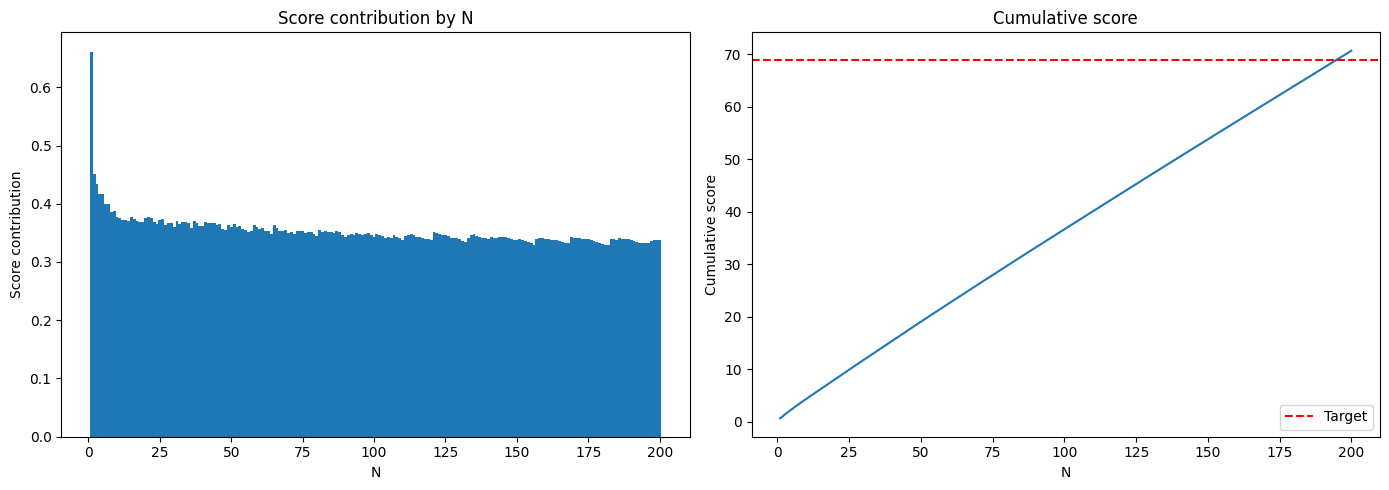

In [4]:
# Plot per-N scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score vs N
ax1 = axes[0]
ns = list(range(1, 201))
scores = [per_n_scores[n] for n in ns]
ax1.bar(ns, scores, width=1)
ax1.set_xlabel('N')
ax1.set_ylabel('Score contribution')
ax1.set_title('Score contribution by N')

# Cumulative score
ax2 = axes[1]
cumulative = np.cumsum(scores)
ax2.plot(ns, cumulative)
ax2.axhline(y=68.919154, color='r', linestyle='--', label='Target')
ax2.set_xlabel('N')
ax2.set_ylabel('Cumulative score')
ax2.set_title('Cumulative score')
ax2.legend()

plt.tight_layout()
plt.show()

In [5]:
# Key insight: To reach target, we need to reduce score by 1.71 points
# This is 2.42% of current score

# If we could improve EVERY N value by 2.42%, we'd reach the target
# But the baseline is already highly optimized

# Let's calculate what improvement we'd need per N
print('Required improvement per N to reach target:')
print('(Assuming uniform 2.42% improvement across all N)')
print()

target = 68.919154
gap = total_score - target
required_reduction_pct = gap / total_score

print(f'Total gap: {gap:.6f}')
print(f'Required reduction: {required_reduction_pct*100:.2f}%')
print()

# For each N, calculate required new score
print('Top 10 N values - required improvement:')
for n, score in sorted_scores[:10]:
    required_new = score * (1 - required_reduction_pct)
    improvement_needed = score - required_new
    print(f'  N={n}: {score:.4f} -> {required_new:.4f} (need -{improvement_needed:.4f})')

Required improvement per N to reach target:
(Assuming uniform 2.42% improvement across all N)

Total gap: 1.711324
Required reduction: 2.42%

Top 10 N values - required improvement:
  N=1: 0.6612 -> 0.6452 (need -0.0160)
  N=2: 0.4508 -> 0.4399 (need -0.0109)
  N=3: 0.4347 -> 0.4242 (need -0.0105)
  N=5: 0.4168 -> 0.4067 (need -0.0101)
  N=4: 0.4165 -> 0.4065 (need -0.0101)
  N=7: 0.3999 -> 0.3902 (need -0.0097)
  N=6: 0.3996 -> 0.3899 (need -0.0097)
  N=9: 0.3874 -> 0.3780 (need -0.0094)
  N=8: 0.3854 -> 0.3761 (need -0.0093)
  N=15: 0.3770 -> 0.3678 (need -0.0091)
